# Exoplanets

This dataset comes from the NASA Exoplanet Archive and lists most of the known exoplanets and their characteristics

Source : https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS

Columns description : https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html

In [1]:
import pandas as pd
from IPython.display import display

from functions.arithm import perc, perc_var
from functions.tools import mem, nan, date_minmax, to_df
from functions.ploting import to_img, plot_counts, plot_disc_meth

In [2]:
df = pd.read_csv('exo_ds.csv', on_bad_lines='skip', low_memory=False)

## Exploration
A quick exploration of this dataset

In [3]:
df.shape

(33376, 121)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33376 entries, 0 to 33375
Columns: 121 entries, rowid to pl_ntranspec;;;;;;
dtypes: float64(69), int64(24), object(28)
memory usage: 30.8+ MB


In [5]:
df.head(10)

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,sy_kepmag,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec;;;;;;
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,1,2,...,NaN,2014-05-14,2008-01,2014-05-14,2,1,2,0,0,0;;;;;;
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,0,2,...,NaN,2014-07-23,2011-08,2014-07-23,2,1,2,0,0,0;;;;;;
2,3,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,...,NaN,2018-04-25,2009-10,2014-05-14,0,1,1,0,0,0;;;;;;
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,0,1,...,NaN,2018-04-25,2011-08,2014-07-23,0,1,1,0,0,0;;;;;;
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,1,1,...,NaN,2018-09-04,2017-03,2018-09-06,0,1,1,0,0,0;;;;;;
5,6,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,1,1,...,NaN,2014-05-14,2008-12,2014-05-14,0,1,1,0,0,0;;;;;;
6,7,14 And b,14 And,b,HD 221345,HIP 116076,TIC 333225860,Gaia DR2 1920113512486282240,0,1,...,NaN,2014-07-23,2011-08,2014-07-23,0,1,1,0,0,0;;;;;;
7,8,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2018-04-25,2004-01,2014-08-21,0,1,4,1,0,0;;;;;;
8,9,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2021-09-20,2021-07,2021-09-20,0,1,4,1,0,0;;;;;;
9,10,14 Her b,14 Her,b,HD 145675,HIP 79248,TIC 219483057,Gaia DR2 1385293808145621504,0,1,...,NaN,2018-04-25,2008-04,2014-08-21,0,1,4,1,0,0;;;;;;


From the top of its 33376 rows and 121 columns, this dataset seems relatively large. 

Based on these first 10 lines, we notice that several planets are duplicated, for example '11 Com b' appears 3 times, which may explain the depth of the dataset. This problem should be addressed in the 'data cleaning' section.

We also notice that the last column seems to have a rather strange syntax: `pl_ntranspec;;;;;;`. This is probably an error that will also have to be fixed in the Data Cleaning part

### Column descriptions

Not all of these 121 columns will be exploited here, but we will nevertheless try to provide a description of those that seem to us to be the most important.

The descriptions of all the columns we have chosen to keep are listed in the file *columns_description.md*

## Data Cleaning
Cleaning up superfluous data

Before starting the cleaning phase, let's keep a few parameters in mind in order to define later in what proportions the dataframe has been reduced

In [6]:
df_mem_before = mem(df, unit='MB')
df_shape_before = df.shape

### Duplicates

In [7]:
df.shape

(33376, 121)

At the date of August 1st 2022 more than 5000 exoplanets could be counted, however, the `shape` function seems to tell us that the dataset has 33376 lines

The reason for this is that this dataset has **several sets of parameters coming from various papers**, each of the exoplanets listed can therefore appear several times (one line for each paper published). Thus, the 33376 lines returned by the `shape` function do not refer to the numbers of exoplanets recorded. 

To illustrate this, let us take as an example the planet WASP-39 b

In [8]:
wasp_39 = df.loc[df['pl_name'] == 'WASP-39 b']
wasp_39

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,sy_snum,...,sy_kepmag,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec;;;;;;
32771,32772,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2019-03-18,2017-06,2019-03-21,0,0,2,0,2,636;;;;;;
32772,32773,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2019-11-27,2018-05,2019-12-05,0,0,2,0,2,636;;;;;;
32773,32774,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-04-27,2016-01,2016-04-28,0,0,2,0,2,636;;;;;;
32774,32775,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-09-06,2016-08,2016-09-08,0,0,2,0,2,636;;;;;;
32775,32776,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2022-08-09,2017-07,2022-08-09,0,0,2,0,2,636;;;;;;
32776,32777,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-01-12,2016-01,2016-01-14,0,0,2,0,2,636;;;;;;
32777,32778,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2015-01-08,2015-02,2015-01-08,0,0,2,0,2,636;;;;;;
32778,32779,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,0,1,...,NaN,2016-10-12,2017-01,2016-10-13,0,0,2,0,2,636;;;;;;
32779,32780,WASP-39 b,WASP-39,b,NaN,NaN,TIC 181949561,Gaia DR2 3643098875168270592,1,1,...,NaN,2014-05-14,2011-07,2014-05-14,0,0,2,0,2,636;;;;;;


We can see that the planet appears 9 times under different publications, at different dates

The dataset presents nevertheless a column named `default_flag` which indicates (by boolean value) the reference exoplanet among those duplicated. For this planet it seems that the 2011 publication is set as default entry.

In [9]:
# Display of the 3 columns that interest us
wasp_39[['pl_name', 'default_flag', 'pl_pubdate']]

,pl_name,default_flag,pl_pubdate
32771,WASP-39 b,0,2017-06
32772,WASP-39 b,0,2018-05
32773,WASP-39 b,0,2016-01
32774,WASP-39 b,0,2016-08
32775,WASP-39 b,0,2017-07
32776,WASP-39 b,0,2016-01
32777,WASP-39 b,0,2015-02
32778,WASP-39 b,0,2017-01
32779,WASP-39 b,1,2011-07


We will use the boolean values of the `default_flag` column to remove duplicate planets from the dataframe, keeping only those with a value of 1.

(1) We will first sort all rows in descending order based on the `default_flag` column, so that all '1's appear first, then we use the 'drop_duplicate' function on the `pl_name` column which, by default, keeps only the first occurrence of the duplicated  (taking care to reset the index). At this point, all duplicate planets have already been deleted, leaving only those with a `True` `default_flag`

(2) Finally, we decide to sort the dataset alphabetically by 'pl_planet'

In [10]:
# 1
df = df.sort_values('default_flag', ascending=False).drop_duplicates('pl_name').reset_index()

# 2
df = df.sort_values('pl_name').reset_index()

df[['pl_name', 'default_flag', 'pl_pubdate']]

,pl_name,default_flag,pl_pubdate
0,11 Com b,1,2008-01
1,11 UMi b,1,2017-03
2,14 And b,1,2008-12
3,14 Her b,1,2022-09
4,16 Cyg B b,1,2017-03
...,...,...,...
5182,ups And b,1,2011-01
5183,ups And c,1,2011-01
5184,ups And d,1,2011-01
5185,ups Leo b,1,2021-12


This deletion of duplicates makes us go directly from a dataset of 33376 lines to 5187 lines, which represents a loss of about 84% but brings us closer to the total number of exoplanets known to date.

### Columns

#### Last column syntax
Let's start with the last column which seemed to have a strange syntax

In [11]:
(df.columns[-1], nan(df.columns[-1], df=df))

('pl_ntranspec;;;;;;', (5187, 100.0))

This column refers to `pl_ntranspec` which denotes the number of literature spectra available for the host star in NASA's exoplanet archive.

Since the column has full integrity, it will not be deleted but only renamed first of all

In [12]:
# Renaming the column
df = df.rename(columns={'pl_ntranspec;;;;;;' : 'pl_ntranspec'})
df.columns[-1]

'pl_ntranspec'

This being done, it turns out that `pl_ntranspec` column data also has the same syntax problem, let's see :

In [13]:
df['pl_ntranspec']

0       0;;;;;;
1       0;;;;;;
2       0;;;;;;
3       0;;;;;;
4       0;;;;;;
         ...   
5182    0;;;;;;
5183    0;;;;;;
5184    0;;;;;;
5185    0;;;;;;
5186    0;;;;;;
Name: pl_ntranspec, Length: 5187, dtype: object

The idea would be to get all the inappropriate syntaxes from the column to keep only the digits

In [14]:
import re

def clean(x):
    x = x.replace(';', '')
    return(int(x))

df['pl_ntranspec'] = df['pl_ntranspec'].apply(clean)
df['pl_ntranspec']

0       0
1       0
2       0
3       0
4       0
       ..
5182    0
5183    0
5184    0
5185    0
5186    0
Name: pl_ntranspec, Length: 5187, dtype: int64

#### Columns integrity
There are 123 columns in this dataset, but do they all have a satisfactory level of integrity? Let's see by using our 'nan' function coded above.

In [15]:
integ_list = []

# We pass each column name to the 'nan' function
for name in df.columns:
    nan_res = nan(name, df=df)
    integ_list.append((name, nan_res[0], nan_res[1]))

integ_df = pd.DataFrame(integ_list, columns=['column name', 'integrity val', 'integrity rate'])

In [16]:
integ_df.describe()

,integrity val,integrity rate
count,123.000000,123.000000
mean,3672.373984,70.799431
std,1922.803769,37.069658
min,9.000000,0.170000
25%,1561.500000,30.105000
50%,5018.000000,96.740000
75%,5187.000000,100.000000
max,5187.000000,100.000000


The `describe` function tells us that the average integrity rate of the columns is 70%, i.e. each column has on average 70% of non-empty data, which is rather satisfactory. However, we notice that at least one column has a relatively low integrity rate (0.17%), we will have to check if other columns are concerned. But before, let's refine these results with a code that allows us to know the integrity of the columns by more precise levels

In [17]:
integ_list = []
cols = len(df.columns)
for ten in range(10, 110, 10):
    lim = len(integ_df.loc[integ_df['integrity rate'] >= ten])
    lim_rate = perc(cols, lim)
    integ_list.append((ten, lim_rate, 100-lim_rate))

integ_more_df = pd.DataFrame(integ_list, columns=['integrity target (rate >=)', 'columns concerned (rate)', 'columns not concerned (rate)'])
integ_more_df.style.set_caption('Analysis by integrity rate bands')

,integrity target (rate >=),columns concerned (rate),columns not concerned (rate)
0,10,93.500000,6.500000
1,20,79.670000,20.330000
2,30,74.800000,25.200000
3,40,72.360000,27.640000
4,50,68.290000,31.710000
5,60,66.670000,33.330000
6,70,63.410000,36.590000
7,80,60.980000,39.020000
8,90,55.280000,44.720000
9,100,41.460000,58.540000


These results tell us that :
- The vast majority of columns have a good integrity rate, this seems to be a good basis for visualizing future statistics :
  - just over 41% of the columns have full integrity 
  - more than 60% have an integrity rate of 80% or higher.
- There are still more than 6% of the columns that have an integrity rate less than or equal to 10%.

In [18]:
# Integrity rate below 1%
low_col = integ_df.loc[integ_df['integrity rate'] <= 1].sort_values(by='integrity rate').reset_index()
low_col

,index,column name,integrity val,integrity rate
0,67,pl_trueobliq,9,0.17
1,62,pl_occdep,18,0.35
2,111,sy_icmag,19,0.37
3,66,pl_projobliq,42,0.81
4,44,pl_cmasse,43,0.83
5,45,pl_cmassj,43,0.83


There are a total of 6 columns in this dataset that have an integrity rate below 1%

In [19]:
df.shape

(5187, 123)

In [20]:
df = df.drop(low_col['column name'], axis=1)

In [21]:
df.shape

(5187, 117)

### Mass

Let's see if there are other mass-related data worth cleaning up (other than `pl_cmass` and `pl_cmassj`).

There are several methods to estimate the mass of an exoplanet, and each of these techniques has its own column :

- `pl_msinie` / `pl_msinij` are planet masses **determined by radial velocity variations of the host star** of the system.
 
- `pl_mass` / `pl_massj` represent masses **determined by techniques targeting the planet** itself (amount and density of matter etc). 

- `pl_bmass` and `pl_bmassj` do not refer to a new measurement technique but simply **retrieve the best mass among those available** (i.e. `pl_mass` or `pl_msini`)

*Reminder : the columns `pl_cmassj` and `pl_cmasse` have been removed above for their low integrity rate*

#### Integrity of mass-related columns

We can start by determining the integrity level of each of these columns.

In [22]:
from utils.column_names import mass_cols

integ_list = []

for name in mass_cols.keys():
    integrity = nan(name, df=df)
    integ_list.append((name, integrity[0], integrity[1]))

integ_df = pd.DataFrame(integ_list, columns=['column name', 'integrity val', 'integrity rate'])
integ_df.style.set_caption('Integrity of mass-related columns')

,column name,integrity val,integrity rate
0,pl_masse,1362,26.260000
1,pl_massj,1362,26.260000
2,pl_msinie,927,17.870000
3,pl_msinij,927,17.870000
4,pl_bmasse,2239,43.170000
5,pl_bmassj,2239,43.170000


This table tells us several things:

- Planetary masses obtained by direct analysis of the planet (`pl_mass` / `pl_massj`) have the **highest integrity rates with over 26%**

- The planetary masses obtained by analysis of the radial velocity variations of the host star present **only an integrity rate of a little more than 17%**.
 
- The last two columns supposed to display the best of the two values, present an integrity rate of more than 43%, which means that about **57% of the exoplanets identified have no known mass**

- The integrity value of `pl_bmass` is 2239 while the sum of the values of `pl_mass` (1362) and `pl_msinie` (927) gives 2289, which suggests that **50 exoplanets have masses informed according to the two calculation methods** (`pl_mass` AND `pl_msini`).

#### Exoplanets without known mass

In [23]:
mass_filter = df[ 
    (df['pl_masse'].isna()) & 
    (df['pl_massj'].isna()) &
    (df['pl_msinie'].isna()) &
    (df['pl_msinij'].isna()) &
    (df['pl_bmasse'].isna()) &
    (df['pl_bmassj'].isna()) 
    ]

mass_filter[[
    'pl_name',
    'pl_masse', 
    'pl_massj', 
    'pl_msinie', 
    'pl_msinij',
    'pl_bmasse',
    'pl_bmassj'
    ]]

,pl_name,pl_masse,pl_massj,pl_msinie,pl_msinij,pl_bmasse,pl_bmassj
127,DS Tuc A b,NaN,NaN,NaN,NaN,NaN,NaN
128,EPIC 201170410.02,NaN,NaN,NaN,NaN,NaN,NaN
129,EPIC 201238110 b,NaN,NaN,NaN,NaN,NaN,NaN
130,EPIC 201427007 b,NaN,NaN,NaN,NaN,NaN,NaN
131,EPIC 201497682 b,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4938,V1298 Tau c,NaN,NaN,NaN,NaN,NaN,NaN
4939,V1298 Tau d,NaN,NaN,NaN,NaN,NaN,NaN
4940,V1298 Tau e,NaN,NaN,NaN,NaN,NaN,NaN
4972,WASP-132 b,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
rate = perc(df.shape[0], mass_filter.shape[0])
known = df.shape[0] - mass_filter.shape[0]
unknown = mass_filter.shape[0]

print(f'Total exoplanets : {df.shape[0]}')
print(f'Exoplanets with known mass : {known} ({perc(df.shape[0], known)}%)')
print(f'Exoplanets with unknown mass : {unknown} ({perc(df.shape[0], unknown)}%)')

Total exoplanets : 5187
Exoplanets with known mass : 2239 (43.17%)
Exoplanets with unknown mass : 2948 (56.83%)


These results confirm the observations made from the previous table : **more than half of the exoplanets counted have no known mass** (about 57%).

We can deduce from these proportions that the calculations leading to the estimation of an exoplanetary mass do not seem to be easy and that they do not represent the norm. **These lack of data seem to be an integral part of the field of exoplanet analysis** and therefore represent a form of information that can be exploited. This is the reason why **none of the exoplanets with unknown mass will be deleted**.

### Dealing with missing data : absence of information is information

This amount of missing data related to the masses of exoplanets calls into question. We can assume that what is valid for characteristics related to mass can also be extrapolated to other characteristics: **it seems difficult for an exoplanet to see all its characteristics filled in**, as evidenced by the average integrity rate of the columns of this dataset estimated above at 70%, **each line of this dataset necessarily presents fragmented data with which it will be necessary to deal**, because the information that can be collected from an exoplanet can, in certain cases, prove to be rare.

Moreover, given the level of data fragmentation, inherent in the field of exoplanets, the idea of deleting all the lines with missing data would lead us irremediably to a zero-dimensional dataset...

### How much has the dataframe shrunk?

Let's see how much the size of the dataframe has been reduced

In [25]:
# Rows
rows_var_val = df_shape_before[0] - df.shape[0]
rows_var_rate = perc_var(df_shape_before[0], df.shape[0])

# Columns
cols_var_val = df_shape_before[1] - df.shape[1]
cols_var_rate = perc_var(df_shape_before[1], df.shape[1])

# Memory
df_mem_now = mem(df, unit='MB')
mem_var_val = df_mem_before - df_mem_now
mem_var_rate = perc_var(df_mem_before, df_mem_now)

# Data structuration
before = (
    df_shape_before[0], 
    df_shape_before[1], 
    round(df_mem_before, 2)
    )

after = (
    df.shape[0], 
    df.shape[1], 
    round(df_mem_now, 2)
    )

varia = (
    f"-{rows_var_val} ({round(rows_var_rate, 2)}%)", 
    f"-{cols_var_val} ({round(cols_var_rate, 2)}%)", 
    f"-{round(mem_var_val, 2)} ({round(mem_var_rate, 2)}%)"
    )

change_list = [before, after, varia]

# Dataframe creation
variation_df = pd.DataFrame(
    change_list, 
    columns=['Rows', 'Columns', 'Memory (MB)'],
    index=['Before', 'After', 'Variation']
    )

variation_df.style.set_caption("Variations before/after data cleaning")

,Rows,Columns,Memory (MB)
Before,33376,121,99.320000
After,5187,117,15.030000
Variation,-28189 (-84.46%),-4 (-3.31%),-84.29 (-84.87%)


At the end of the data cleaning process, the dataframe has lost 28189 rows or about 84% (removal of duplicates) and 4 columns (those with a very low integrity rate). These deletions have **reduced the memory space of the dataframe by more than 84%** from 100MB to 15MB

## Analysis and Visualizations

In [26]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image # Convert bytes to image

### Discoveries over the years

In order to get an idea of the dynamism in the field of exoplanet research, let's make a graphic representation of the number of exoplanets discovered per year

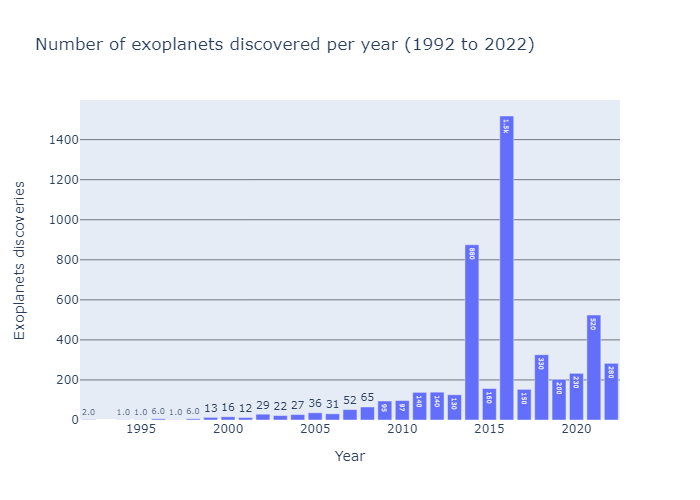

In [27]:
disc_year = df['disc_year'].value_counts()

plot_counts(
    disc_year, 
    x_label='Year', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per year (1992 to 2022)'
    )

The number of exoplanets discovered each year follows an upward trend, but the years **2014 and 2016 seem to have been particularly prolific** for the discovery of exoplanets.

### Telescopes and discovery methods

All these discoveries have been made with telescopes of different sizes, based on the ground or in space and using different detection methods.

#### Telescopes

Firstable it would be interesting to see if a telescope stands out from the crowd by the number of its discoveries, let's take a look at the years 2014 and 2016

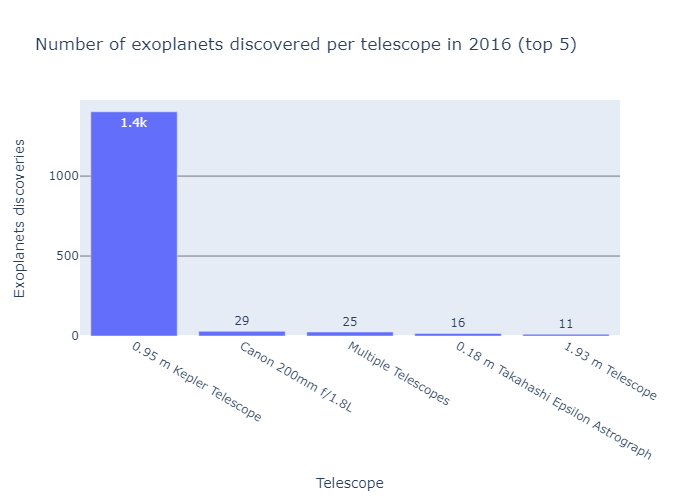

In [28]:
# 2016 telescopes analysis
y_2016 = df.loc[df['disc_year'] == 2016]
y_2016 = y_2016['disc_telescope'].value_counts()

plot_counts(
    y_2016,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope in 2016 (top 5)'
    )

The graph clearly shows us that during 2016, **the Kepler telescope was behind almost all exoplanet discoveries**. Let's quickly see if this is also the case for the year 2014

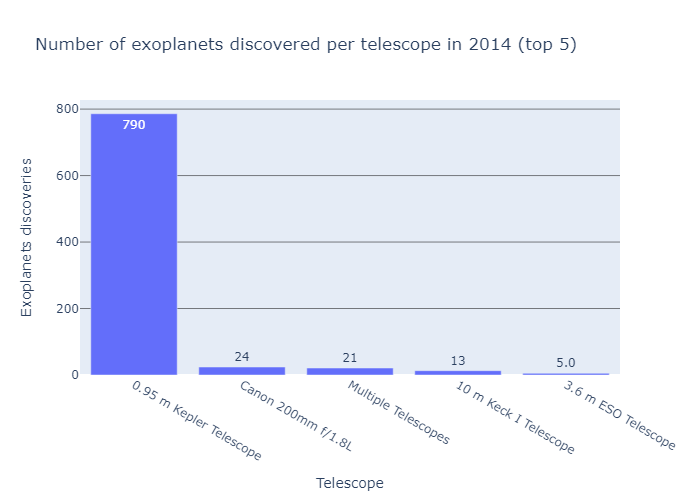

In [29]:
# 2014 telescopes analysis
y_2014 = df.loc[df['disc_year'] == 2014]
y_2014 = y_2014['disc_telescope'].value_counts()

plot_counts(
    y_2014,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope in 2014 (top 5)'
    )

Also during 2014, the Kepler telescope stood out atop its 786 exoplanets discovered, only 24 for the second place finisher.

Based only on the years 2014 and 2016, **Kepler seems to represent a major asset to the detection of exoplanets**, to confirm this, it would be interesting to measure its overall contribution.

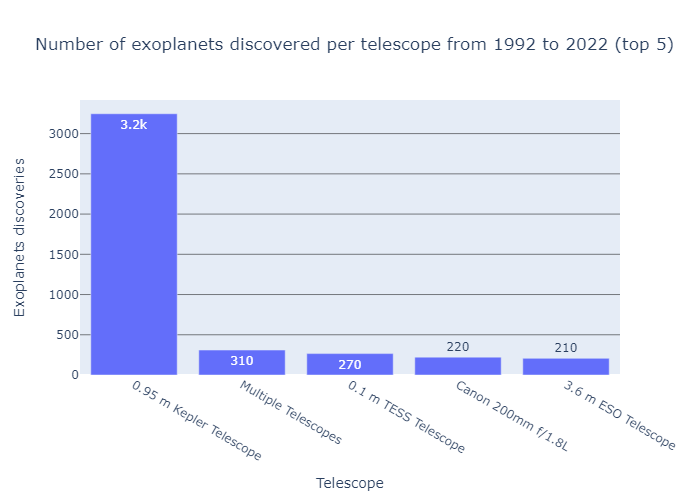

In [30]:
telesc = df['disc_telescope'].value_counts()

plot_counts(
    telesc,
    to=5, 
    x_label='Telescope', 
    y_label='Exoplanets discoveries',
    title='Number of exoplanets discovered per telescope from 1992 to 2022 (top 5)'
    )

Here again, the result is clear, **the Kepler space telescope is a major player in the search for exoplanets**, it has discovered 3247 of the 5187 listed in this dataset, i.e a little more than 62% (almost 2/3 !)

##### Kepler

**A brief history :**

The Kepler space telescope, launched in 2009, was designed by NASA with the specific goal of discovering exoplanets by transit method. Its tremendous contribution to this field of research is all the more incredible given its chaotic lifespan :

- **2009** : **detections have been made more difficult** due to the noise generated by the telescope electronics, which turned out to be more important than expected, and by the luminosities of stars which are much more variable than anticipated, complicating the interpretation of the light curves. 
- **2010** : One of the detection modules fails without hope of being repaired, resulting in a **5% decrease in the field of view**
- **2012** : One of the 4 reaction wheels used to orient the telescope does not work anymore, the telescope which needs at least 3 wheels, is in **critical situation**
- **2013** : One of the 3 remaining wheels breaks down, the telescope is now obliged to use its ergol to orient itself which **does not allow to reach the same precision of pointing**
- **2014** : The telescope cannot maintain permanently its orientation. It uses the photonic thrust to compensate the two missing wheels, but this artifice imposes to frequently modify the observed region of space so that the radiations do not penetrate the telescope aperture. Because of these regular changes of axis, the **telescope can now only identify planets with a very short orbital period**.
- **2018** : After having used all the ergol to maintain its orientations, the reserve was exhausted. **The telescope can no longer ensure its mission**.

It is despite this particularly turbulent life that Kepler was able to discover more than half of the exoplanets listed

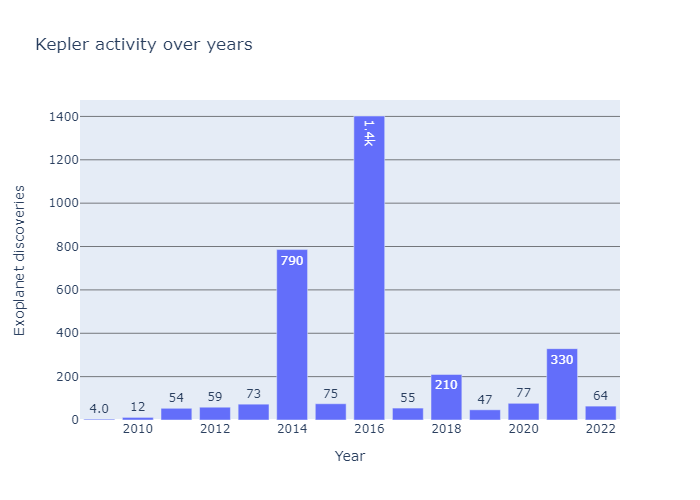

In [31]:
# Kepler activity per year
kepler = df.loc[df['disc_telescope'] == '0.95 m Kepler Telescope']
kepler = kepler['disc_year'].value_counts()

plot_counts(kepler, 
x_label='Year', 
y_label='Exoplanet discoveries',
title='Kepler activity over years'
)

In [32]:
# Average discoveries per year
kepler.mean()

231.92857142857142

These repeated technical problems could partly explain its very heterogeneous level of activity over the years (figure above).

>Note : **discovery made in a given year does not mean that the telescope photograph also dates from that same year**. Indeed, telescopes can send a large mass of information that can take time to analyze, sometimes several years. This is the reason why Kepler continues to "discover" exoplanets after 2018, the year of its end of service.

Despite its end of service in 2018, another space telescope will take over the same year: TESS

##### TESS

TESS (Transiting Exoplanet Survey Satellite) is a new space telescope launched in 2018 (Kepler's end of service year) by NASA and also designed to detect exoplanets by transit method.

Its smaller size than Kepler does only allow it to detect the closest and brightest planets (up to 100x brighter than those detected by Kepler), but these specializations seem to bear fruit because as shown in the graph above (*Number of exoplanets discovered per telescope from 1992 to 2022*), it is already **the 3rd largest contributor of exoplanet discoverer**.

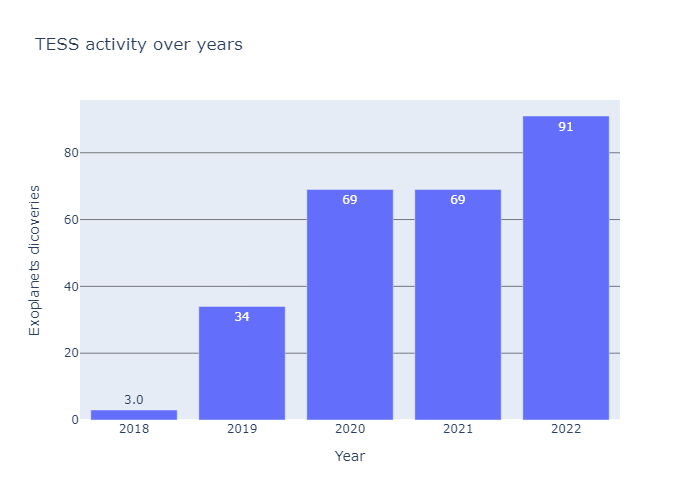

In [33]:
tess = df.loc[df['disc_telescope'] == '0.1 m TESS Telescope']
tess = tess['disc_year'].value_counts()

plot_counts(tess,
x_label='Year',
y_label='Exoplanets dicoveries',
title='TESS activity over years')

In [34]:
# Average discoveries per year
tess.mean()

53.2

In [35]:
kepler = df.loc[df['disc_telescope'] == '0.95 m Kepler Telescope']
kepler = kepler['disc_year'].value_counts()

print('First 5 years of activity :')
print('TESS discoveries : ',tess.sort_index().sum())
print('Kepler discoveries : ', kepler.sort_index()[0:5].sum())

First 5 years of activity :
TESS discoveries :  266
Kepler discoveries :  202


And despite its smaller size and instruments, **TESS discovered 64 more exoplanets than Kepler in the same period**. This telescope seems to be well on its way to fully take over from Kepler

##### ESO

ESO (European Southern Observatory) is a group of ground-based telescopes located in the southern hemisphere and operated by an intergovernmental European organization founded in 1962. It is currently the **main actor of observational astronomy in Europe**.

The group has about twenty observing instruments and telescopes ranging from 2.2 to 8.20 meters in diameter, all based in Chile and **capable of imaging, photometry, spectroscopy and interferometry observations** in almost all wavelengths.

The most active telescope in the discovery of exoplanets in this dataset seems to be a telescope with a diameter of 3.6 meters based in La Silla and entered into service in 1976.

Let's see how involved it has been in the search for exoplanets over the years.

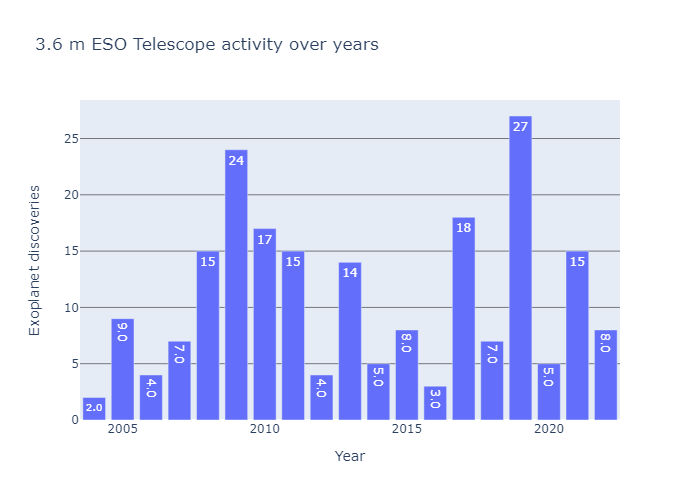

In [36]:
eso = df.loc[df['disc_telescope'] == '3.6 m ESO Telescope']
eso = eso['disc_year'].value_counts()

plot_counts(eso, 
x_label='Year', 
y_label='Exoplanet discoveries',
title='3.6 m ESO Telescope activity over years'
)

In [37]:
round(eso.mean(), 2)

10.89

The telescope started its observations early, in 2004, 5 years before Kepler was commissioned and although ESO's main mission is not the search for exoplanets, its long contribution over the years has led to the discovery of more than 200 extra-solar planets, making it the 5th most important contributor.

#### Discovery methods

There are several methods to detect exoplanets, they can vary depending on the characteristics of the planet and the telescope, but can also in some cases be combined to refine the results. Let's take a brief look at some of these methods :

- **Radial velocity** : the planets slightly attract their sun towards them, if the observer is on the same orbital plane, the star of the system will appear slightly closer and then farther away, which in spectroscopy will result in slight redshifts and blueshift. These **variations of frequencies observed make it possible to estimate the minimum mass of the planets**. The more massive the planet, the more obvious these frequency variations will be and the easier the detection will be. 
  
  For this technique **it is essential that the observer is aligned on the orbital plane of the star**, if he is on a perpendicular or close plane, he will not be able to observe the variations of luminous intensity sought. Moreover, the gas of certain stars contracts and relaxes periodically, which could be wrongly attributed to a variation of its radial velocity, other stars still have their intrasic luminosity which varies periodically, an information which here again can be misinterpreted. All this implies knowing the characteristics of the star well before confirming with certainty the presence of a planet.

- **Transit** : the observer sees the **planet passing in front of its star**, which allows to determine its period of rotation, its radius but also to estimate its mass. Like the radial velocity method, this one requires that the observer be on the same orbital plane as the target star, indeed, in the event that the observer is slightly above or below this plane, he will never observe the planet passing in front of its star.

- **Astrometric variation** : If the method by radial velocity allows to deduce the presence of a planet only if the observer is on the same orbital plane, the method by astrometric variation allows to **observe the slight variation of position of the host star when the observer is on a perpendicular plane** (above or below the star). Seen from above (or bolow), the movement of the star will no longer appear rectilinear but as slightly slaloming, it is these curvatures in the path of the star that make it possible to estimate the presence of planets in its system. The main drawback of this method is that it requires a long and continuous follow-up of the star to confirm the periodicity of its curvatures and therefore involves a long monopolization of the resources of the telescope used for the detection.

- **Microlensing** : A massive star projects its light rays in the direction of the target star, these rays are distorted by the target star (which acts as a lens, hence the name of the method) due to the curvature of space-time caused by its mass, if a planet orbits around the target star then the luminous deformations will be locally more intense on the side where it is located. This method has the disadvantage of requiring an almost perfect alignment between the observer and the target star, which happens only very rarely.

- **Imaging** : Detection of the planet by **direct imaging**, which requires state-of-the-art equipment with very high resolution. This method represents a major challenge for the research and analysis of exoplanets, several projects are being studied or built for this purpose, including telescopes over 30 meters in diameter.

- **Pulsar Timing Variation** : Some planets orbit a pulsar: the remnant of a star that exploded in a supernova, leaving behind an extremely dense neutron star that rotates well periodically and rapidly (sometimes one revolution in milliseconds). During these rotations, the star emits powerful electromagnetic radiation which can be detected on earth in the form of very regular pulses. The method consists of **periodically detecting slight desynchronizations in the radiation of the pulsar**, which may indicate the presence of one or more planets in its system. Indeed, the pulsar moves slightly back and forth attracted by the planets which surrounds it, the speed of light being constant, just like the speed of rotation of the pulsar, the light emitted will take more or less time to arrive up to the observer, **the degree of variation of these frequencies gives indications on the mass and the orbit of the planets**. If the technique is very precise, pulsars are on the other hand particularly rare.

- **Eclipse Timing Variation** : This method is **used when the host star is binary**, ie made up of two stars orbiting one around the other. With no nearby planets, **the system's overall luminosity varies at fairly regular intervals** as one star blocks the light of the other by eclipsing. However, **when planets are present, these eclipses may appear a little earlier or a little later** due to the gravitational disturbances generated; **These variations give precious indications on the potential presence of planets in the system**. If binary stars are very common in the galaxy and in the universe (more than half), the planets orbiting there turn out to be generally far from their stars, which complicates the detection of gravitational disturbances present on them.

Let's see what are the most used detection methods

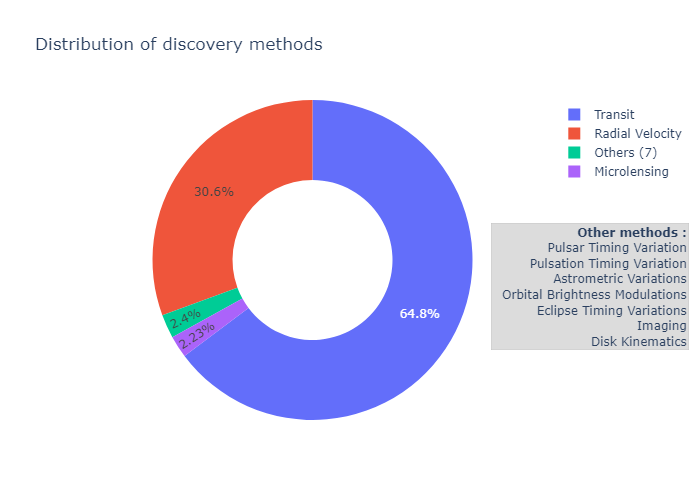

In [38]:
plot_disc_meth(
    df, 
    merge_low=80,
    title='Distribution of discovery methods')

The graph tells us that **transit and radial velocity seem to be the two main methods of detecting exoplanets**.

Almost 65% of exoplanet detections are made by transit method (almost 2/3), just over 30% by radial velocity, around 2% by microlensing, while all other methods combined (7 in total) only represent a little more than 2% of detection techniques

> **Note** : As we will see later, **an exoplanet can combine several detection methods**, so the given percentage of the use of a method does not mean that it was the only one used by exoplanet

Now let's see the detection methods used by the main telescopes. For each of them we will, on the one hand, present the shares represented by all the methods of observation identified, and on the other hand, in another graph, compare the two main methods in order to determine if they combine, and if so, in what proportions.

##### Kepler discovery methods

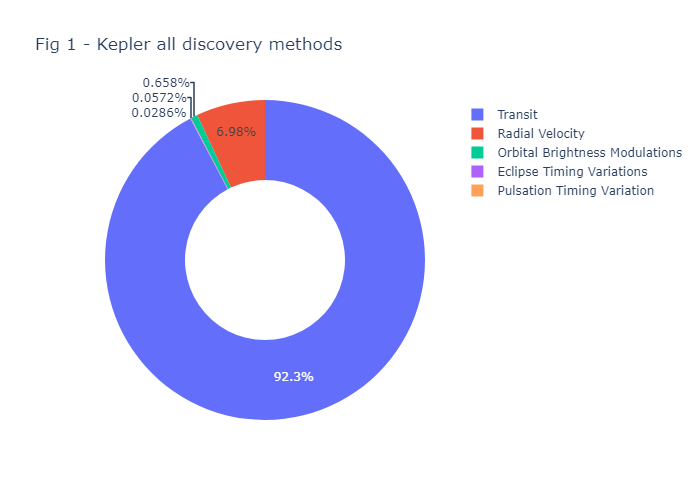

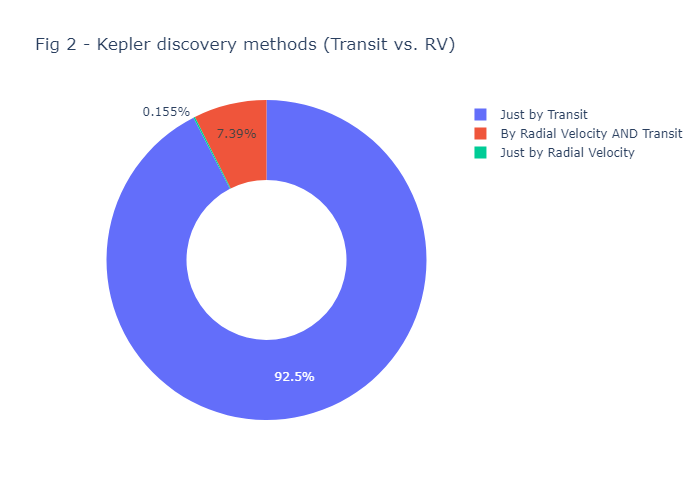

In [39]:
# Kepler discovery methods
kepler = df.loc[df['disc_telescope'] == '0.95 m Kepler Telescope']

fig_1 = plot_disc_meth(kepler, 
    title='Fig 1 - Kepler all discovery methods')

fig_2 = plot_disc_meth(kepler, duo=['tran_flag', 'rv_flag'],
    title='Fig 2 - Kepler discovery methods (Transit vs. RV)')

display(fig_1, fig_2)

**Fig 1** :

**Almost all of the telescope's observations were made by transit method** (92%) and almost 7% by radial velocity, while a small number of observations (0.7%) share 3 other observation methods.

Let's compare its 2 main methods to see if they can be combined and if so, in what proportions

**Fig 2** :

This graph teaches us that **an observation by radial velocity is almost systematically combined with an observation by transit**, as evidenced by the small number of observations by radial velocity alone.

Conversely, observations by transit method alone remain largely in the majority with more than 92%

Observation data are therefore only crossed in 7% of cases.

##### TESS discovery methods

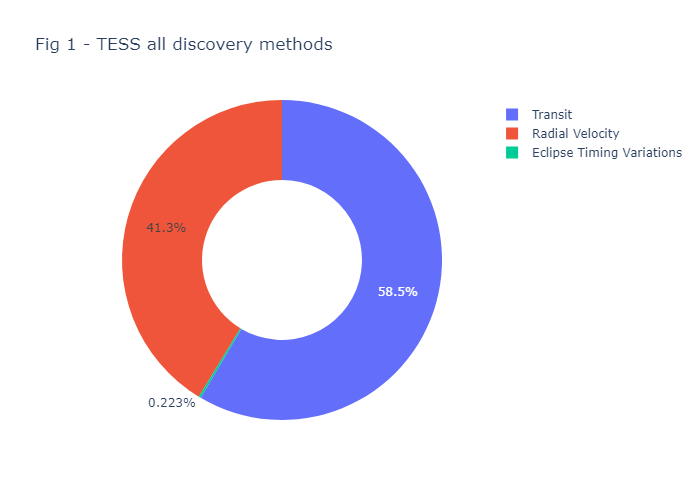

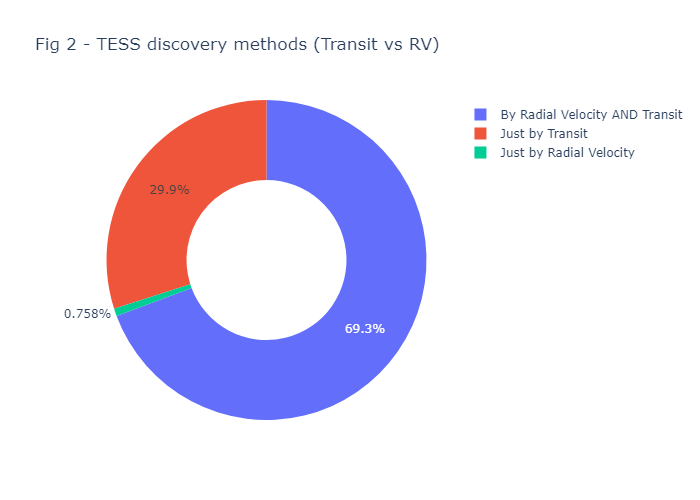

In [40]:
# TESS discovery methods
tess_meth = df.loc[df['disc_telescope'] == '0.1 m TESS Telescope']

fig_1 = plot_disc_meth(
    tess_meth, 
    title='Fig 1 - TESS all discovery methods')

fig_2 = plot_disc_meth(
    tess_meth, 
    duo=['tran_flag', 'rv_flag'],
    title='Fig 2 - TESS discovery methods (Transit vs RV)'
    )

display(fig_1, fig_2)

**Fig 1** : 

The two observation methods, transit and radial velocity, seem more evenly distributed with 58% and 41% respectively. The method by eclipse timing variations representing only a tiny portion (0.22%).

Let's take a look at the relationship between transit and radial velocity methods

**Fig 2** :

The interesting information that emerges from these data from the TESS telescope is that its **detections by the radial velocity method are almost systematically coupled to a transit method**, as evidenced by the tiny percentage of observations made solely by the radial velocity method (0.7% ).

The proportion of detections made solely by the transit method are on the other hand much more numerous (around 30%).

Finally, we note that almost **70% of the detections made by the telescope combine the two methods** (transit + RV) which accentuates the precision and reliability of these discoveries.

##### ESO discovery methods

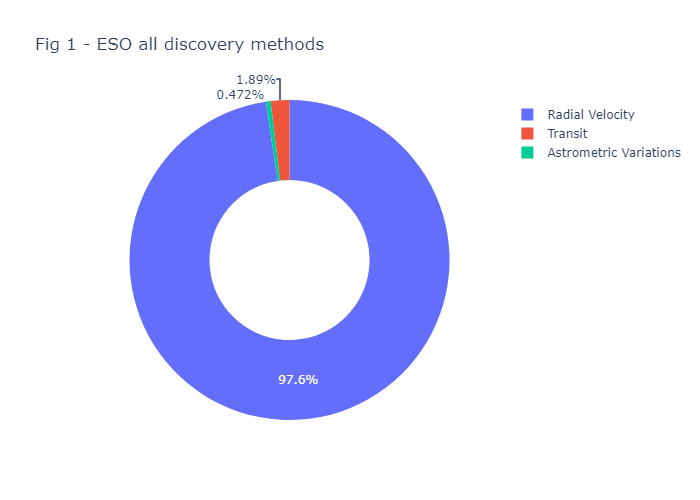

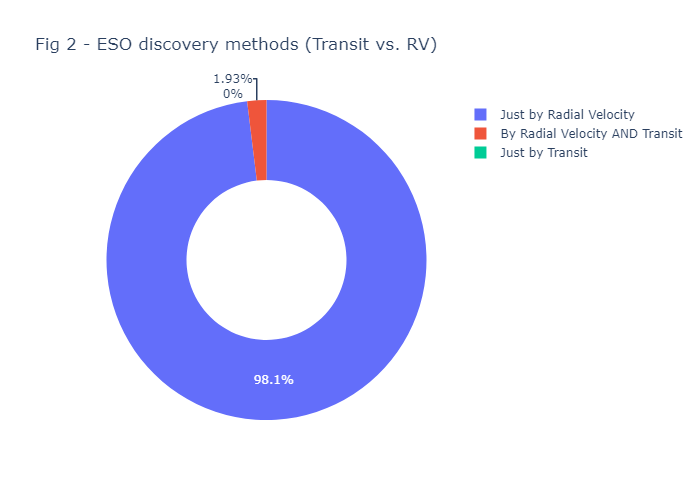

In [41]:
# ESO discovery methods
eso = df.loc[df['disc_telescope'] == '3.6 m ESO Telescope']

fig_1 = plot_disc_meth(
    eso,
    title='Fig 1 - ESO all discovery methods'
    )

fig_2 = plot_disc_meth(
    eso,
    title='Fig 2 - ESO discovery methods (Transit vs. RV)',
    duo=['tran_flag', 'rv_flag']
    )

display(fig_1, fig_2)

**Fig 1** :

Unlike the Kepler and TESS space telescopes which mainly use the transit method, **the ESO terrestrial telescope almost exclusively uses the radial velocity method (97%)**.

**Fig 2** :

Here too, for almost all of the observations (98%) only the radial velocity method was used, without any other crossing.


### Mass

### Distance from us

### Some correlations

#### Year of observation vs. Planet's distance from us

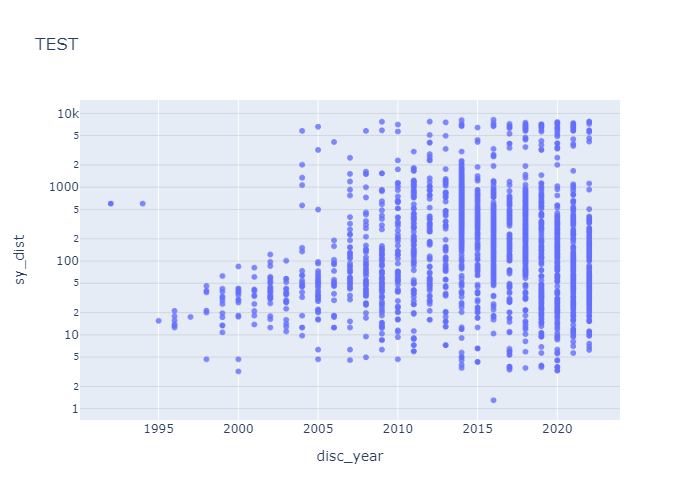

In [63]:
test = df.loc[
    (df['sy_dist'].notna()) & 
    (df['disc_year'].notna()) &
    (df['pl_orbsmax'].notna())
    ]

fig_1 = px.scatter(
    test, 
    x='disc_year', 
    y='sy_dist', 
    log_x=False,
    log_y=True,
    title='TEST',
    labels={'x': 'Year', 'y': 'Distance [parsec]'},
    #color='pl_orbsmax',
    opacity=0.8
    )

fig_1.update_yaxes(
    showgrid=True,
    gridcolor='black',
    gridwidth=0.1
    )

to_img(fig_1)

#### Mass vs. distance from star

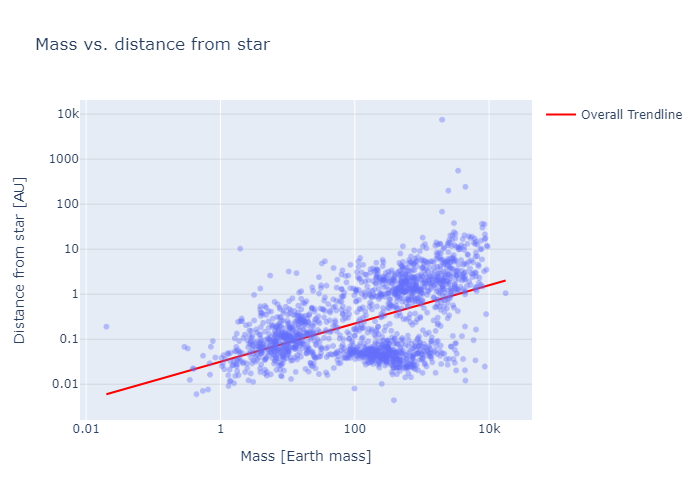

In [94]:
test = df.loc[
    (df['pl_bmasse'].notna()) & 
    (df['pl_orbsmax'].notna()) &
    (df['pl_orbper'].notna())
    ]

fig_1 = px.scatter(
    test, 
    x='pl_bmasse', 
    y='pl_orbsmax', 
    log_x=True,
    log_y=True,
    title='Mass vs. distance from star',
    labels={
        'pl_bmasse': 'Mass [Earth mass]', 
        'pl_orbsmax': 'Distance from star [AU]'},
    #symbol='rv_flag',
    #color='pl_rade',
    opacity=0.4,
    trendline='ols',
    trendline_color_override='red',
    #trendline_label='TEST',
    trendline_options=dict(log_y=True, log_x=True),
    trendline_scope='overall'
    )

#fig_1.update_traces(marker_color='grey')

fig_1.update_yaxes(
    showgrid=True,
    gridcolor='black',
    gridwidth=0.1
    )

to_img(fig_1)